# Data Science for Quantitative Finance (CMDA 4984) Final Project
#### Pranav Thiriveedhi
#### Monte Carlo Simulation to Determine Equity Value of a Company

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yahoo_fin import stock_info as si
import pandas_datareader as dr

Input variables for Microsoft. (MSFT)

In [2]:
company_ticker = 'MSFT'
market_risk_premium = 0.042
debt_return = 0.00519
long_term_growth = 0.014
tax_rate = 0.148
iterations = 1000


Financial Information from Yahoo! Finance

In [3]:
income_statement_df = si.get_income_statement(company_ticker)
pars_df = income_statement_df.loc[['totalRevenue', 'ebit']]
input_df = pars_df.iloc[:, ::-1]

In [4]:
input_df

endDate,2018-06-30,2019-06-30,2020-06-30,2021-06-30
Breakdown,,,,
totalRevenue,110360000000,125843000000,143015000000,168088000000
ebit,35058000000,42959000000,53145000000,69916000000


Calculate average revenue CAGR & EBIT margin

In [5]:
def get_cagr(past_revs):
    CAGR = (past_revs.iloc[0,3]/past_revs.iloc[0,0])**(1/4)-1
    return(CAGR)

def get_average_margin(past_ebit):
    margin = 0
    margin_lst = []
    
    for i in range(len(past_ebit.columns)):
        margin = past_ebit.iloc[1,i]/past_ebit.iloc[0,i]
    
    margin_lst.append(margin)
    return(sum(margin_lst)/len(margin_lst))

mean_cagr = get_cagr(input_df)
mean_margin = get_average_margin(input_df)

In [6]:
print("Avg Revenue CAGR: ", mean_cagr)
print("Avg Revenue EBIT Margin: ", mean_margin)

Avg Revenue CAGR:  0.11091608373093576
Avg Revenue EBIT Margin:  0.415948788729713


Create forecast function for random variables

In [7]:
def get_forecast(input_df, cagr, margin, long_term_growth):
    forecast_lst = []
    for i in range(6):
        if i < 5:
            forecast_lst.append(input_df.iloc[0,3]*(1+cagr)**(i+1)*margin)
        else:
            forecast_lst.append(input_df.iloc[0,3]*(1+cagr)**(i)*(1+long_term_growth)*margin)
    return forecast_lst

Get WACC and net debt

In [8]:
def get_wacc(company_ticker, market_risk_premium, debt_return, tax_rate):
    risk_free_rate_df = dr.DataReader('^TNX', 'yahoo') 
    risk_free_rate = (risk_free_rate_df.iloc[len(risk_free_rate_df)-1,5])/100
    equity_beta = si.get_quote_table('msft')['Beta (5Y Monthly)']
    equity_return = risk_free_rate+equity_beta*(market_risk_premium)
    balance_sheet_df = si.get_balance_sheet(company_ticker)
    short_term_debt_series = balance_sheet_df.loc['shortLongTermDebt']
    long_term_debt_series = balance_sheet_df.loc['longTermDebt']
    cash_series = balance_sheet_df.loc['cash']
    net_debt = short_term_debt_series.iloc[0] +  + long_term_debt_series.iloc[0] - cash_series.iloc[0]
    market_cap_str = si.get_quote_table(company_ticker)['Market Cap']
    market_cap_lst = market_cap_str.split('.')

    if market_cap_str[len(market_cap_str)-1] == 'T':
        market_cap_length = len(market_cap_lst[1])-1
        market_cap_lst[1] = market_cap_lst[1].replace('T',(12-market_cap_length)*'0')
        market_cap = int(''.join(market_cap_lst))

    if market_cap_str[len(market_cap_str)-1] == 'B':
        market_cap_length = len(market_cap_lst[1])-1
        market_cap_lst[1] = market_cap_lst[1].replace('B',(9-market_cap_length)*'0')
        market_cap = int(''.join(market_cap_lst))

    company_value = market_cap + net_debt
    WACC = market_cap/company_value * equity_return + net_debt/company_value * debt_return * (1-tax_rate)
    return WACC

In [9]:
def get_net_debt():
    
    balance_sheet_df = si.get_balance_sheet(company_ticker)
    short_term_debt_series = balance_sheet_df.loc['shortLongTermDebt']
    long_term_debt_series = balance_sheet_df.loc['longTermDebt']
    cash_series = balance_sheet_df.loc['cash']

    return short_term_debt_series.iloc[0] + long_term_debt_series.iloc[0] - cash_series.iloc[0]
    
mean_wacc = get_wacc(company_ticker, market_risk_premium, debt_return, tax_rate)

net_debt = get_net_debt()

Discount EBIT figures to arrive at the PV of the firm's cash flows

In [10]:
def discount(forecast, discount_rate, long_term_rate):
    discount_lst = []
    for x,i in enumerate(forecast):
        if x < 5:
            discount_lst.append(i/(1+discount_rate)**(x+1))
        else:
            discount_lst.append(i/(discount_rate-long_term_rate)*(1/(1+discount_rate)**5))
    return sum(discount_lst)

Run simulation and plot distribution of model forecasts

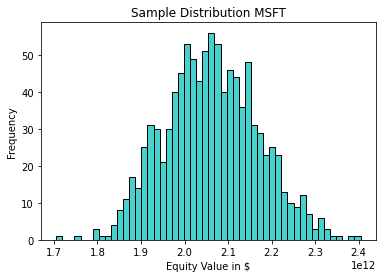

In [11]:
hist_lst = []

for i in range(iterations):
    cagr = np.random.normal(mean_cagr, 0.01)
    margin = np.random.normal(mean_margin, 0.005)
    long_term_rate = np.random.normal(long_term_growth, 0.001)
    discount_rate = np.random.normal(mean_wacc, 0.001)
    forecast = get_forecast(input_df, cagr, margin, long_term_rate)
    hist_lst.append(discount(forecast, discount_rate, long_term_rate)-net_debt)

    
hist_array = np.array(hist_lst)
plt.hist(hist_array, bins=50, align='mid', color = 'mediumturquoise', edgecolor='black')
plt.title('Sample Distribution ' + company_ticker)
plt.xlabel('Equity Value in $')
plt.ylabel('Frequency')

plt.show()

In [12]:
mean = hist_array.mean()
standard_error = hist_array.std()/(iterations**(1/2))

lower_bound = mean-1.96*standard_error
upper_bound = mean+1.96*standard_error 

print(lower_bound)
print(upper_bound)

2055162246276.1755
2068399976013.527


In [18]:
print(company_ticker)
print("Avg Revenue CAGR: ", mean_cagr)
print("Avg Revenue EBIT Margin: ", mean_margin)
formatted_lb = "${:,.2f}".format(lower_bound)
formatted_ub = "${:,.2f}".format(upper_bound)

print("Equity Value: ", [formatted_lb, formatted_ub])


MSFT
Avg Revenue CAGR:  0.11091608373093576
Avg Revenue EBIT Margin:  0.415948788729713
Equity Value:  ['$2,055,162,246,276.18', '$2,068,399,976,013.53']
